# Amazon Simple Storage Service (S3) Tutorial

In this tutorial, we describe the paths supported by the public S3 bucket. We also make an example query to the container to get asteroid data for (705) Erminia. With these data, we show how to make a light curve. Note that "light-curve" is not standard asteroid terminology, but we keep this usage here as it is common elsewhere in astronomy.

## Install `requirements`

To begin, users can optionally create a python virtual enviroment and install the following requirements in the root of the directory while the virtual environment is activated:

```
pip install -r requirements.txt
```

## Import relevant libraries

To begin, we want to import the necessary libraries for the bucket to be used correctly. Note that users will have to install additional dependencies as part of the `astropy` package. Specifically, users will need `fsspec` and `s3fs` to be able to correctly access the S3 bucket via `astropy` commands (see [Extracting via `astroquery`](#extracting-via-astroquery)). Users can look at the __[installing `astropy`](https://docs.astropy.org/en/stable/install.html#installing-astropy)__ directions for more details. Alternatively, users can import `fsspec` and `pip install s3fs` (see [Extracting via direct installation of `fsspec` and `s3fs`](#extracting-via-direct-installation-of-fsspec-and-s3fs)).

In [33]:
# import libraries
import fsspec # optional depending on the astropy dependencies installed
import sys
import ipynbname
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.visualization import astropy_mpl_style
from astropy.io import fits
from astropy.time import Time
from pathlib import Path

# Get the absolute path of the current notebook
nb_path = Path(ipynbname.path()).resolve()

ROOT = nb_path.parents[2]

# Add project root to sys.path
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from ast_ftns import find_ast

plt.style.use(astropy_mpl_style)
sns.set_theme(style='ticks')
%matplotlib inline

## Request and extract data

Next, we want to make a call to the bucket. This call will always be in the form of a path containing relevant parameters. In this example, we are making a call to the S3 path, which will return a `.FITS` file containing data to generate a light curve. The data that are returned include the flux (mJy), flux error (mJy), normalization factors, and time of observation (unix). The general format for this query is `s3://cornell-acteroids/asteroid_lc_array_frequency.fits`. The parameters to change are `asteroid`, `array`, and `frequency`. 

By loading in this file, we can extract data by calling the relevant column names from the `.FITS` file header. Here, we collect the time of observation, flux from each measurement, and flux error. In this example, we are collecting data for the asteroid (705) Erminia on ACT array pa6 at 90 GHz. 

As part of the data products, we provide the asteroid weighting calculation for each asteroid. This weighting is based on the Rayleigh-Jeans approximation for the __[Standard Thermal Model](https://www.sciencedirect.com/science/article/pii/0019103586900217?via%3Dihub)__ and considers the earth-asteroid distance as well as the earth-asteroid-sun angle. 

The only parameters users need to change are `asteroid`, `array`, and `frequency`. For this example, we collect data for (705) Erminia on ACT array pa6 at a frequency of 90 GHz.

In [34]:
# create request to ACTeroids container
asteroid = 'Erminia'
array = 'pa6'
frequency = '090'

Once the user selects these three parameters, obtaining the data is a matter of creating the correct S3 path and extracting the relevant data, as one would for a `.FITS` file. The code below does not need to be modified in any way.

In [35]:
name = f'{asteroid}_lc_{array}_{frequency}' # this is the final format of the string

s3_path = 's3://cornell-acteroids/' + name + '.fits'

Extracting data is slightly different depending on the installation procedure. See [Extracting via `astroquery`](#extracting-via-astroquery) when the `fsspec` and `s3fs` libraries are installed along with astropy. Otherwise, see [Extracting via direct installation of `fsspec` and `s3fs`](#extracting-via-direct-installation-of-fsspec-and-s3fs) for those doing direct installation of these two packages.

### Extracting via `astroquery`

Below lies code for installing the `fsspec` and `s3fs` libraries via `astroquery`.

In [36]:
with fits.open(s3_path, fsspec_kwargs={"anon": True}) as hdul:  
    data = hdul[1].data

### Extracting via direct installation of `fsspec` and `s3fs`

If users decide instead to `import fsspec` and `pip install s3fs`, then the following code should be used to open data from AWS.

In [37]:
with fsspec.open(s3_path, 'rb', anon=True) as fileobj:
    with fits.open(fileobj) as hdul:
        data = hdul[1].data

Once data are collected, then data from the columns can be collected as follows.

In [38]:
# get data from each column
times = data['Time']
flux = data['Flux']
error = data['FluxUncertainty']
weight = data['Weight']

## Light curves

To make light curves, we take the times, flux, and error bars and create a scatter plot. Note that the term "light curve" is not standard in the asteroid community, but we wish to increase the accessibility of these data to the broader astronomy community, so we keep this usage.

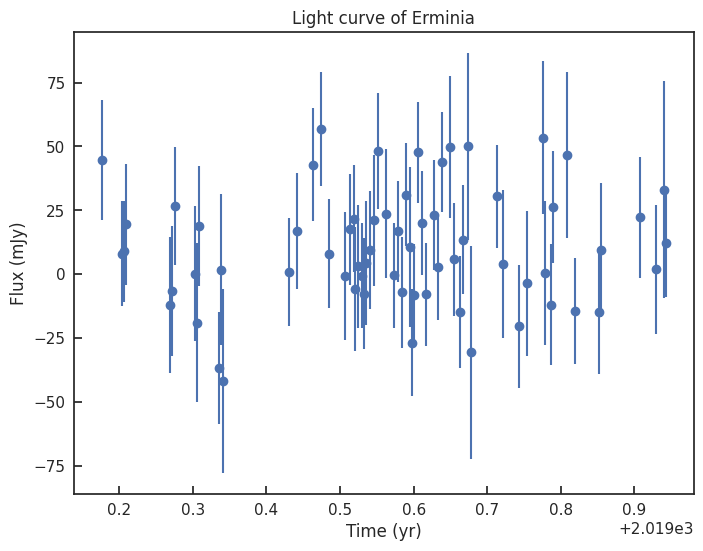

In [39]:
# convert from Unix to years
t = Time(times, format="unix")
years = t.decimalyear

# create and display scatter plot with error bars
plt.errorbar(years, flux, yerr=error, fmt='o')
plt.tick_params(direction='in')
plt.title(f'Light curve of {asteroid}')
plt.xlabel('Time (yr)')
plt.ylabel('Flux (mJy)')
plt.savefig('Erminia_lcurve.pdf')
plt.show()

## Demonstration of the `find_ast()` function.

Here, we show how to use the `find_ast()` function defined in the `ast_ftns` script. This function prints the file name for a given asteroid. The file contains the ACT array and frequency (GHz) of observation. We can see if two asteroids, Vesta and Ceres, exist in this database. If so, `find_ast()` prints the `.FITS` file(s) associated with them.

In [40]:
find_ast("Vesta")
find_ast("Ceres")

Vesta_lc_night_pa4_150.fits
Vesta_lc_night_pa4_220.fits
Vesta_lc_night_pa5_090.fits
Vesta_lc_night_pa5_150.fits
Vesta_lc_night_pa6_090.fits
Vesta_lc_night_pa6_150.fits
Ceres_lc_night_pa4_150.fits
Ceres_lc_night_pa4_220.fits
Ceres_lc_night_pa5_090.fits
Ceres_lc_night_pa5_150.fits


## References

For more information about this data set, see [Orlowski-Scherer et al. 2024](https://iopscience.iop.org/article/10.3847/1538-4357/ad21fe/meta).